# Importing necessary libraries

In [1]:
import os
import yaml

from PIL import Image
from pprint import pprint
from torchvision import transforms
from transformers import (
    AutoImageProcessor,
    DPTForDepthEstimation,
    pipeline,
    AutoModelForDepthEstimation,
)
import torch
import torch.nn.functional as F
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import requests
import urllib.request

from data_processing import simcol
from Depth_Anything_V2.metric_depth.depth_anything_v2 import dpt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

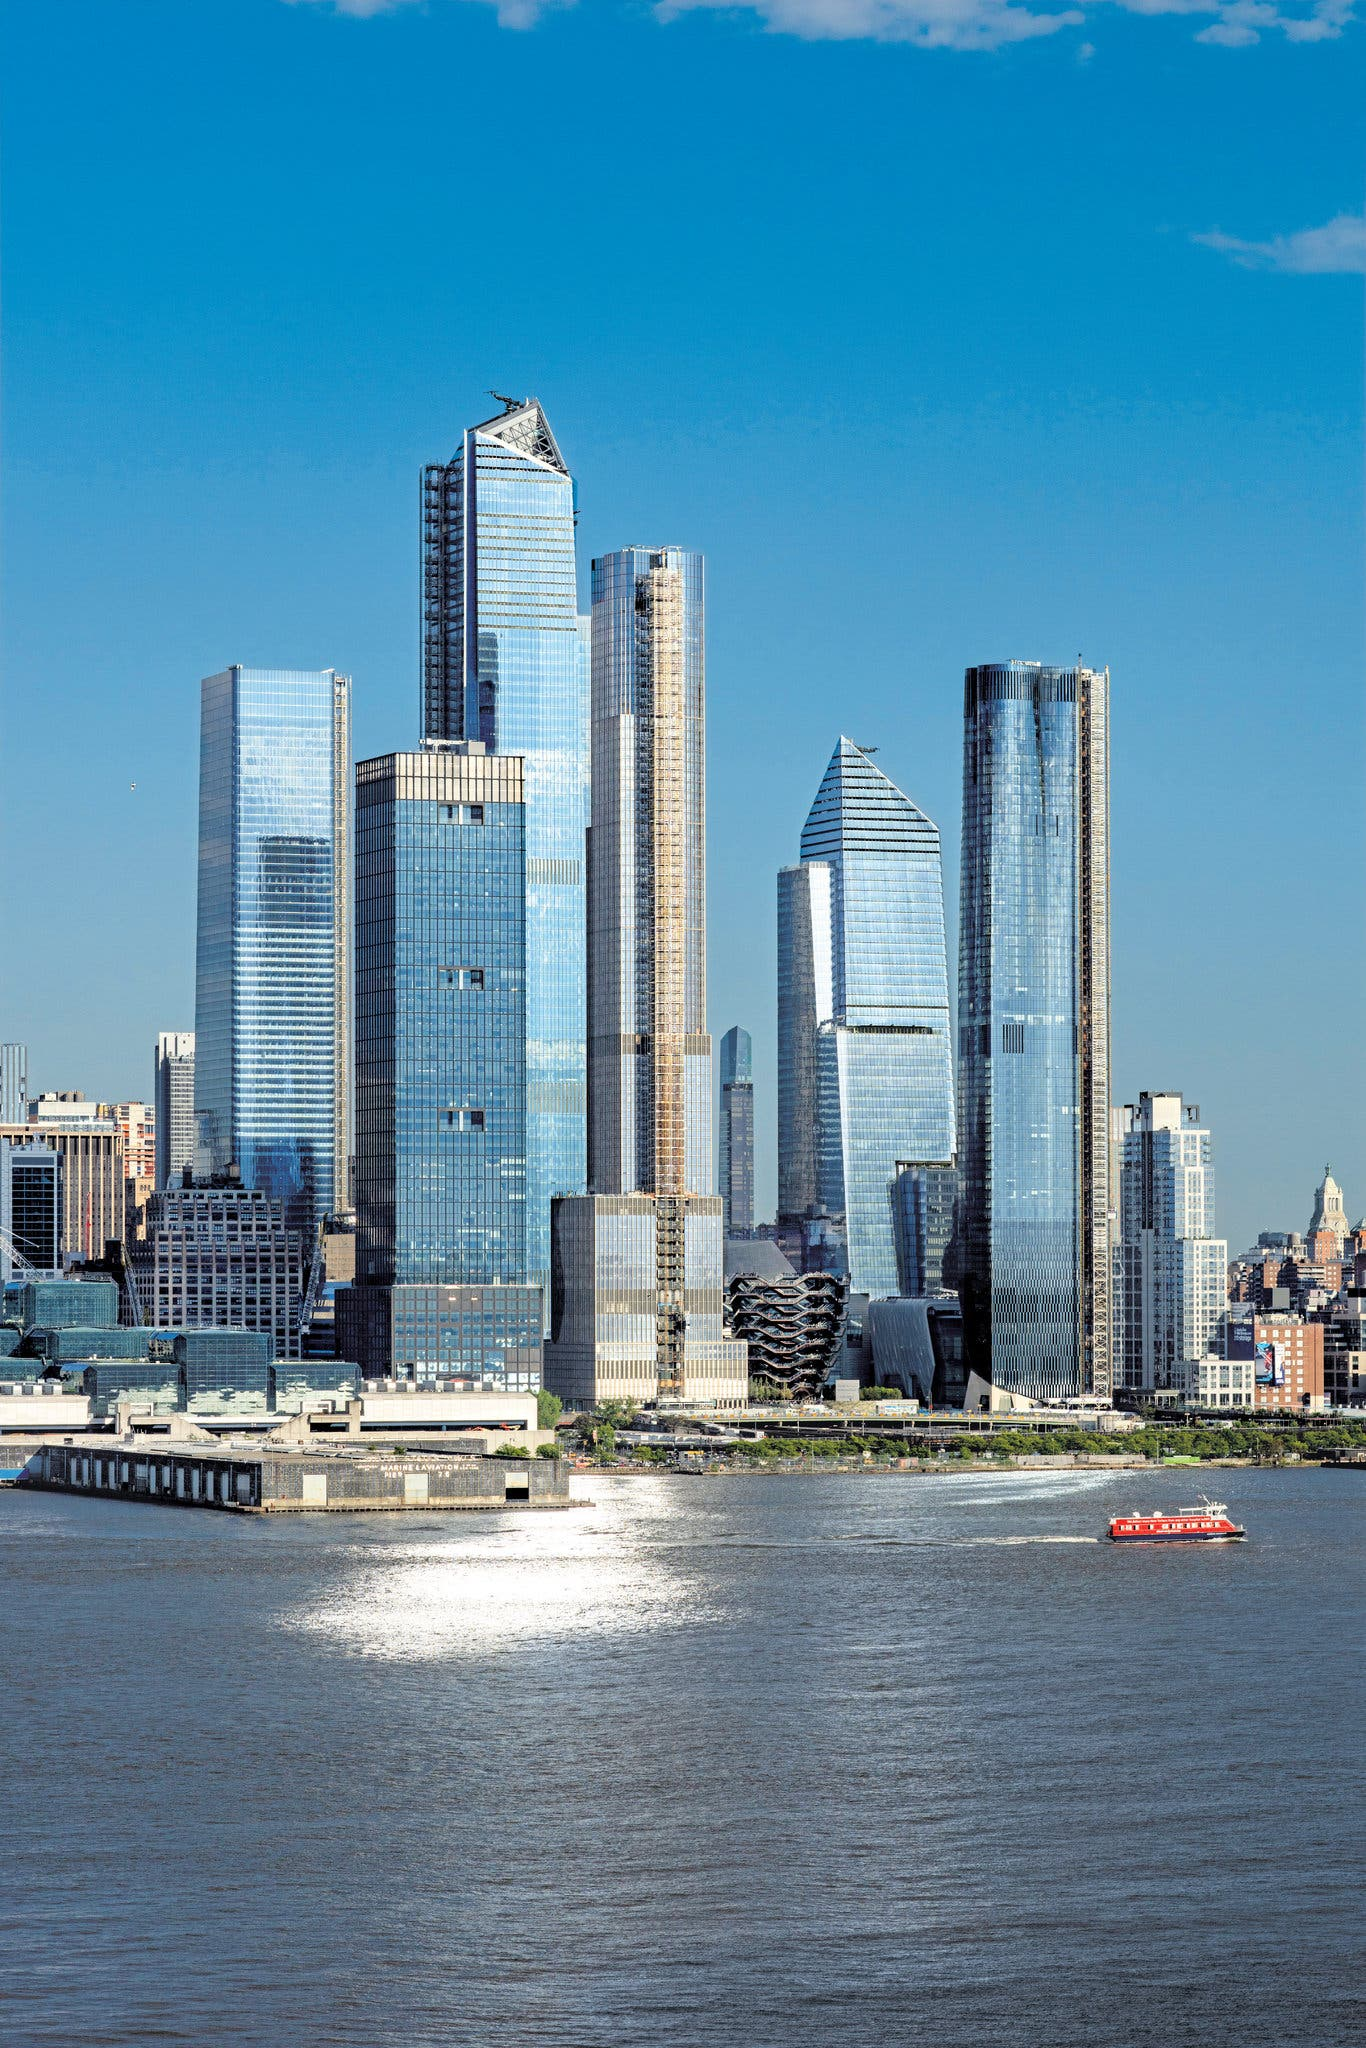

In [6]:
image_url = "https://static01.nyt.com/images/2019/05/29/realestate/00skyline-top/86b2f16d7f7a462c903cea4f134ac440-superJumbo.jpg?quality=75&auto=webp"
# image_url = "https://poseidonanimalhealth.com.au/cdn/shop/articles/Glossy_Horse_2048x.jpg?v=1700546417"
image = Image.open(requests.get(image_url, stream=True).raw)
image
# print(image.shape[:2])
# im

# Depth Anything v2 vs DINOv2

Source:
1. Depth Anything v2: https://huggingface.co/docs/transformers/en/model_doc/depth_anything_v2
2. DINOv2: https://huggingface.co/facebook/dpt-dinov2-base-kitti

In [7]:
def depth_dam(image):
    image_processor = AutoImageProcessor.from_pretrained(
        "depth-anything/Depth-Anything-V2-Small-hf"
    )
    model = AutoModelForDepthEstimation.from_pretrained(
        "depth-anything/Depth-Anything-V2-Small-hf"
    )

    # prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # interpolate to original size and visualize the prediction
    post_processed_output = image_processor.post_process_depth_estimation(
        outputs,
        target_sizes=[(image.height, image.width)],
    )

    predicted_depth = post_processed_output[0]["predicted_depth"]
    depth = (predicted_depth - predicted_depth.min()) / (
        predicted_depth.max() - predicted_depth.min()
    )
    depth_dam = depth.detach().cpu().numpy() * 255
    return depth_dam.astype(np.uint8)


def depth_dino(image):
    image_processor = AutoImageProcessor.from_pretrained(
        "facebook/dpt-dinov2-base-kitti"
    )
    model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-base-kitti")

    # prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    return formatted

In [8]:
cmap = matplotlib.colormaps.get_cmap("Spectral")
# depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
pred_dam = depth_dam(image)
pred_dino = depth_dino(image)
pred_dam = (cmap(pred_dam)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)
pred_dino = (cmap(pred_dino)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)

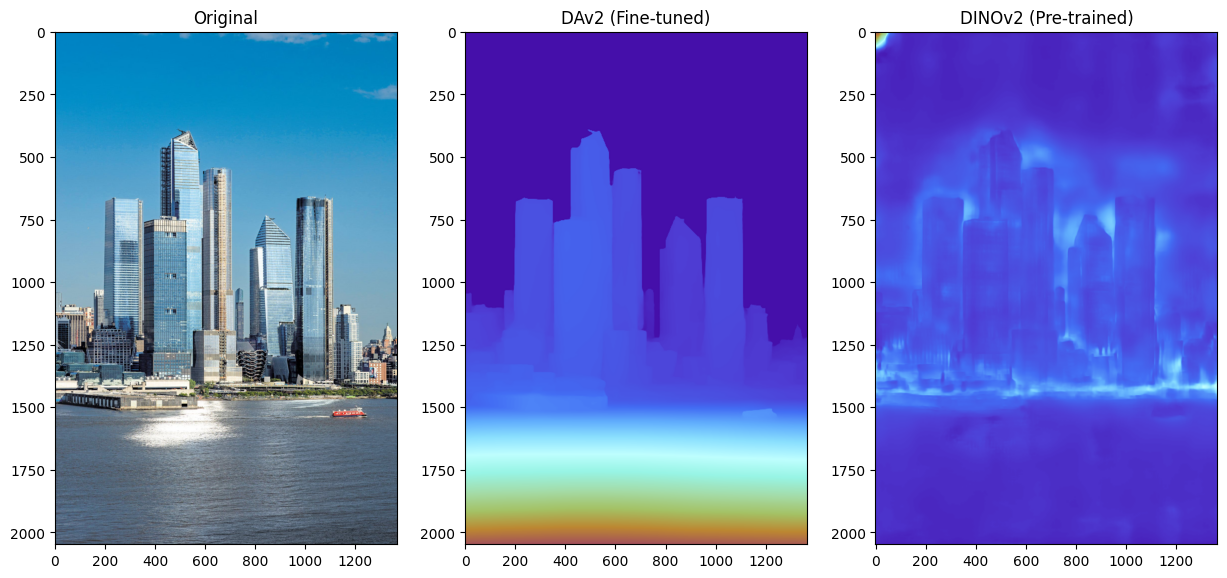

In [9]:
def visualize(dam, dino):
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(Image.fromarray(dam), cmap="Spectral")
    plt.title("DAv2 (Fine-tuned)")
    # plt.colorbar()

    # Original Depth Map
    plt.subplot(1, 3, 3)
    plt.imshow(Image.fromarray(dino), cmap="Spectral")
    plt.title("DINOv2 (Pre-trained)")
    # plt.colorbar()
    plt.show()


visualize(pred_dam, pred_dino)

In [2]:
encoder = "vitl"  # vits, vitl

model_configs = {
    "vits": {
        "encoder": "vits",
        "features": 64,
        "out_channels": [48, 96, 192, 384],
    },
    "vitb": {
        "encoder": "vitb",
        "features": 128,
        "out_channels": [96, 192, 384, 768],
    },
    "vitl": {
        "encoder": "vitl",
        "features": 256,
        "out_channels": [256, 512, 1024, 1024],
    },
    "vitg": {
        "encoder": "vitg",
        "features": 384,
        "out_channels": [1536, 1536, 1536, 1536],
    },
}

pretrained_from = f"./base_checkpoints/depth_anything_v2_{encoder}.pth"
model = dpt.DepthAnythingV2(**model_configs[encoder])

model.load_state_dict(
    {
        k: v
        for k, v in torch.load(
            pretrained_from,
            map_location="cpu",
        ).items()
        if "pretrained" in k
    },
    strict=False,
)
model.to(device)
model.eval()

2025-04-28 15:56:36,064 - INFO - using MLP layer as FFN


/tmp/ipykernel_2171167/2406720044.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  for k, v in torch.load(


DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

In [3]:
# Display original depth map and image
def display_original(img, dep, pred=None):
    plt.figure(figsize=(15, 5))

    # Original Image
    if pred is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(img[:, :, :3], cmap="gray" if len(img.shape) == 2 else None)
        plt.title("Original Image")
        plt.colorbar()

        # Original Depth Map
        plt.subplot(1, 3, 2)
        plt.imshow(dep, cmap="Spectral")
        plt.title("Original Depth Map")
        plt.colorbar()

        # Predicted Depth Map
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="Spectral")
        plt.title("Predicted Depth Map")
        plt.colorbar()

    else:
        plt.subplot(1, 2, 1)
        plt.imshow(img[:, :, :3], cmap="gray" if len(img.shape) == 2 else None)
        plt.title("Original Image")
        plt.colorbar()

        # Original Depth Map
        plt.subplot(1, 2, 2)
        plt.imshow(dep, cmap="Spectral")
        plt.title("Original Depth Map")
        plt.colorbar()

    plt.show()

In [4]:
image = np.array(
    Image.open(
        "./datasets/SyntheticColon/SyntheticColon_I/Frames_S1/FrameBuffer_0000.png"
    )
)[:, :, :3]
image_np = image.astype(np.float32) / 255.0  # Convert to [0,1] range
depth = Image.open(
    "./datasets/SyntheticColon/SyntheticColon_I/Frames_S1/Depth_0000.png"
)  # Convert to [0,1] range
depth_np = np.array(depth).astype(np.float32) / 65535.0

In [6]:
pred_depth = model.infer_image(image)
# pred_depth

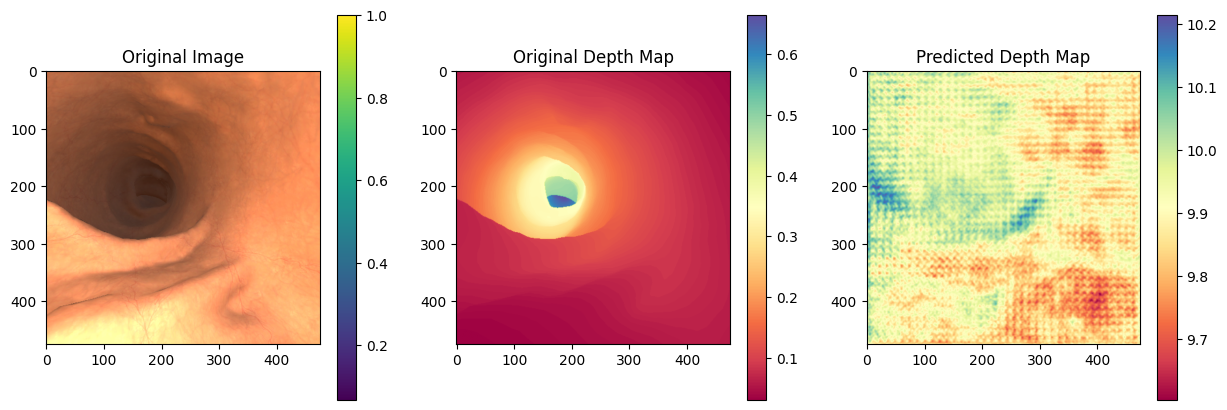

In [7]:
display_original(image_np, depth_np, pred_depth)